In [19]:
import pennylane as qml
import numpy as np
from qutip import Bloch
# 定义量子设备，支持状态向量模拟
dev = qml.device("default.qubit", wires=4)




In [20]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 64              # Number of samples for each training step
num_epochs = 1             # Number of training epochs
num_experiences = 10        # Number of experiences
num_classes = 200            # Number of classes in the dataset
train_mb_size= 256            # Number of samples for each training step
eval_mb_size=100            # Number of samples for each evaluation step
memory_size = 2000          # Number of total samples in the memory
q_depth = 4                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
alpha=0.5                   # the weight of the old model in the loss function
temperature=2.0             # temperature for the distillation loss

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def phase_layer(w):
    """Layer of S gates and T gates to flip the phase of the qubits.
    """
    for idx in range(w):
        if idx % 2 == 0:
            qml.S(wires=idx)
        else:
            qml.T(wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [22]:
@qml.qnode(dev)
def quantum_state(q_input_features, q_weights_flat):
    """
    计算量子态。
    """
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    H_layer(n_qubits)  # 施加 Hadamard 门
    RX_layer(q_input_features)  # 施加 RX 旋转门
    
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    return qml.state()  # 只返回量子态

In [23]:
state = quantum_state(np.random.random(n_qubits), np.random.random(q_depth * n_qubits))
print("量子态: ", state)

量子态:  [-0.06329999+0.17394989j -0.04202999+0.11549943j -0.01397052+0.03839133j
 -0.01524357+0.04188968j  0.02624113-0.07211126j -0.00126122+0.00346586j
  0.04030267-0.11075271j  0.04696672-0.12906569j  0.01965483-0.05401195j
  0.16121595-0.44302529j  0.14312481-0.39331041j  0.07701119-0.21162861j
  0.08906804-0.24476113j  0.15983418-0.43922817j  0.0866193 -0.23803191j
  0.11153501-0.30650089j]


Bloch 球坐标:  [0.04550322504645809, 8.673617379884035e-18, 0.01915881500475638]


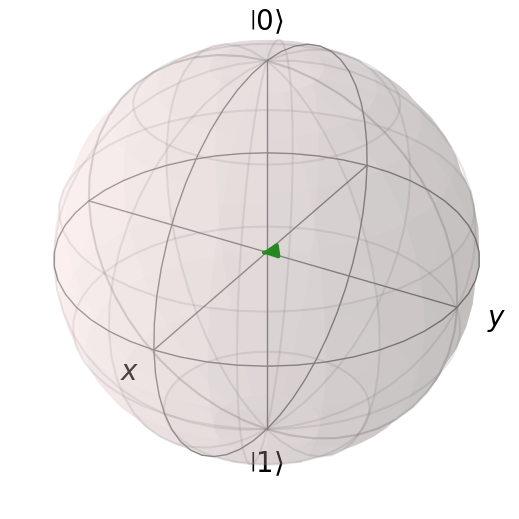

In [25]:
# 计算 Bloch 球坐标
bloch_vector = [2 * np.real(state[0] * np.conj(state[1])),
                2 * np.imag(state[0] * np.conj(state[1])),
                np.real(state[0] * np.conj(state[0]) - state[1] * np.conj(state[1]))]

print("Bloch 球坐标: ", bloch_vector)

# 绘制 Bloch 球
b = Bloch()
b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
b.show()